In [39]:
from langchain.llms import OpenAI
from langchain.tools.python.tool import PythonAstREPLTool
from langchain.schema import AgentAction, AgentFinish
from langchain.schema.messages import BaseMessage, SystemMessage, AIMessage
from langchain.agents.openai_functions_agent.base import OpenAIFunctionsAgent, _format_intermediate_steps, _FunctionsAgentAction
from langchain.callbacks.manager import Callbacks
from langchain.agents.agent import AgentExecutor

from typing import Union, TypeVar, List, Tuple, Any
import json
from json import JSONDecodeError

class CustomPythonAstREPLTool(PythonAstREPLTool):
    name = "python"
    description = (
        "A Python shell. Use this to execute python commands. "
        "The input must be an object as follows: "
        "{'__arg1': 'a valid python command.'} "
        "When using this tool, sometimes output is abbreviated - "
        "Make sure it does not look abbreviated before using it in your answer. "
        "Don't add comments to your python code."
    )

def _parse_ai_message(message: BaseMessage) -> Union[AgentAction, AgentFinish]:
    """Parse an AI message."""
    if not isinstance(message, AIMessage):
        raise TypeError(f"Expected an AI message got {type(message)}")

    function_call = message.additional_kwargs.get("function_call", {})

    if function_call:
        function_call = message.additional_kwargs["function_call"]
        function_name = function_call["name"]
        try:
            _tool_input = json.loads(function_call["arguments"])
        except JSONDecodeError:
            print(
                f"Could not parse tool input: {function_call} because "
                f"the `arguments` is not valid JSON."
            )
            _tool_input = function_call["arguments"]

        # HACK HACK HACK:
        # The code that encodes tool input into Open AI uses a special variable
        # name called `__arg1` to handle old style tools that do not expose a
        # schema and expect a single string argument as an input.
        # We unpack the argument here if it exists.
        # Open AI does not support passing in a JSON array as an argument.
        if "__arg1" in _tool_input:
            tool_input = _tool_input["__arg1"]
        else:
            tool_input = _tool_input

        content_msg = "responded: {content}\n" if message.content else "\n"

        return _FunctionsAgentAction(
            tool=function_name,
            tool_input=tool_input,
            log=f"\nInvoking: `{function_name}` with `{tool_input}`\n{content_msg}\n",
            message_log=[message],
        )

    return AgentFinish(return_values={"output": message.content}, log=message.content)

class CustomOpenAIFunctionsAgent(OpenAIFunctionsAgent):
    def plan(
        self,
        intermediate_steps: List[Tuple[AgentAction, str]],
        callbacks: Callbacks = None,
        **kwargs: Any,
    ) -> Union[AgentAction, AgentFinish]:
        """Given input, decided what to do.
        Args:
            intermediate_steps: Steps the LLM has taken to date, along with observations
            **kwargs: User inputs.
        Returns:
            Action specifying what tool to use.
        """
        user_input = kwargs["input"]
        agent_scratchpad = _format_intermediate_steps(intermediate_steps)
        prompt = self.prompt.format_prompt(
            input=user_input, agent_scratchpad=agent_scratchpad
        )
        messages = prompt.to_messages()
        predicted_message = self.llm.predict_messages(
            messages, functions=self.functions, callbacks=callbacks
        )
        agent_decision = _parse_ai_message(predicted_message)
        return agent_decision
    

In [40]:
import pandas as pd
portfolio_df = pd.read_csv("T10Y2Y-short.csv")
# df.head()
len(portfolio_df)

125

In [41]:
from langchain.chat_models import ChatOpenAI
import openai

from langchain.agents.agent import AgentExecutor

import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

# openai.api_key  = os.environ['OPENAI_API_KEY']
openai.api_key= os.environ['OPENAI_API_KEY']

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0613")

In [42]:
# prefix = 'You are an economist and expert in econometrics.'
# prefix="You are a market analyst."
prefix = 'You are a portfolio engineer who analyze stock portfolios. You are given a portfolio_df to analyze.'

dataset={"portfolio_df": portfolio_df}
tools = [CustomPythonAstREPLTool(locals=dataset)]
tool_names = [tool.name for tool in tools]
prompt = CustomOpenAIFunctionsAgent.create_prompt(system_message=SystemMessage(content=prefix))
agent = AgentExecutor.from_agent_and_tools(
    agent=CustomOpenAIFunctionsAgent(llm=llm, prompt=prompt, tools=tools, verbose=True),
    tools=tools, verbose=True
)

agent.run("How many rows are there?")




> Entering new  chain...

Invoking: `python` with `len(portfolio_df)`


125There are 125 rows in the portfolio_df.

> Finished chain.


'There are 125 rows in the portfolio_df.'



> Entering new  chain...

Invoking: `python` with `import matplotlib.pyplot as plt

plt.plot(portfolio_df['Date'], portfolio_df['T10Y2Y'])
plt.xlabel('Date')
plt.ylabel('T10Y2Y')
plt.title('T10Y2Y against Date')
plt.xticks(rotation=45)
plt.show()`




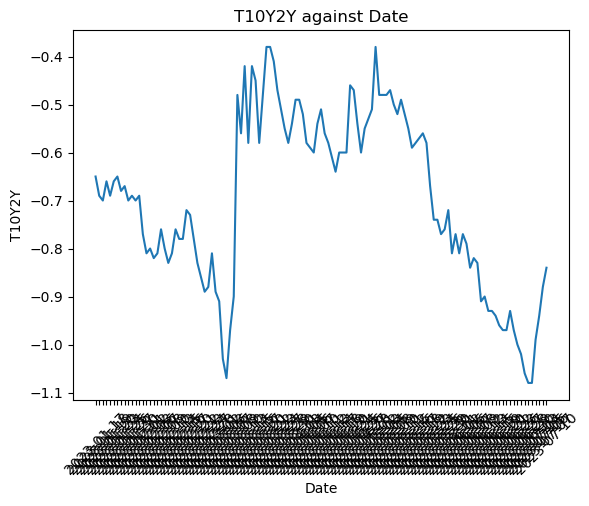

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 1.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-b9LeZA4q56k2CbxEtZPS9Sdj on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 2.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-b9LeZA4q56k2CbxEtZPS9Sdj on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues..




> Finished chain.


''

In [43]:
agent.run("""Don't create a sample data. Only use data from portfolio_df.
          In portfolio_df, Date column has the dates and T10Y2Y column has the values. Please plot a line chart of T10Y2Y against Date""")

### prompt1: plotting

In [44]:
# agent.run("""In the given dataframe, portfolio_df, DATE column is the dates. T10Y2Y column is the values.
#           The dataframe is sorted by DATE column.
#           Do not create a sample data. 
#           Only use given data, plot a line chart with x-axis being DATE and y-axis being T10Y2Y. """)

In [45]:
# agent.run("""In the given portfolio dataframe, Stock column is the stock tickers.
#           Sector column is each stock's sector. Weight column is stock weights in the portfolio. Return column is stock performance. 
#           The table is sorted by Return column in descending order. 
#           Do not create a new dataframe. 
#           Only use given portfolio, comment which stocks are the worst performers with the least returns?""")